### Imports & Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [14]:
import re
import datetime
import matplotlib
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
%matplotlib notebook

In [5]:
pd.__version__
sns.__version__

'1.1.3'

'0.11.0'

### Define utils

In [15]:
from typing import List, Dict, NamedTuple


def pg_array2datetime_list(pg_array_string: str, datetime_format: str = '%Y-%m-%d %H:%M:%S.%f'
                           ) -> List[datetime.datetime]:
    '''Converts postgres array of timestamps (string) into list
    of datetimes, for use as pandas DataFrame converter
    '''
    return [datetime.datetime.strptime(d, datetime_format)
            for d in pg_array_string.strip('{}').split(',')]


def find_all_match_group_positions(pattern: str, string: str) -> Dict[str, List]:
    '''
    Uses re.finditer() to return all match groups and corresponding
    start positions of a regex pattern in a string.

    Args:
        pattern (str): regex pattern
        string (str)

    Returns:
        match_positions (defaultdict(list)): keys are match groups & 
            values are group start positions (list(int))
    '''
    match_positions = defaultdict(list)
    [match_positions[m.group()].append(m.start())
     for m in re.finditer(pattern, string)]
    return match_positions


def extract_match_group_timestamps(match_group: str, 
                                   ts_list: List[datetime.datetime]) -> List[datetime.datetime]:
    '''
    Use this to parse results of find_all_match_group_positions.

    For supplied match_group (i.e. event sequence), use corresponding 
    match start positions as indices of datetime list to find start datetime of event sequence.

    Args:
        match_group (str)
        ts_list (list(datetime))

    Returns:
        list(datetime): start timestamps of match_group

    '''
    return [ts_list[ind] for ind in matches.get(match_group)] if matches.get(match_group) else None


def timedelta2days(timedelta: datetime.timedelta, tolerance=0) -> int:
    '''Convert time delta to days by rounding total seconds of duration'''
    return round(timedelta.total_seconds()/86400, tolerance)

### Distribution of Endorsement Events

#### Load CSV

In [6]:
adf = pd.read_csv('../data/endorsements_atts_dist.csv')
adf

ts_endorsement  year  is_sse  \
0      2020-03-05 16:43:41.825000  2020    True   
1      2020-06-13 19:42:36.444000  2020   False   
2      2020-08-02 18:12:35.295000  2020   False   
3      2018-05-15 19:11:37.209000  2018   False   
4      2019-09-17 18:05:17.121000  2019   False   
...                           ...   ...     ...   
37721  2019-01-31 14:02:01.049000  2019   False   
37722  2020-01-15 01:46:14.043000  2020   False   
37723  2020-04-01 21:51:22.266000  2020   False   
37724  2018-10-22 20:25:26.966000  2018   False   
37725  2018-12-28 15:03:40.147000  2018   False   

                            broker_segment                 first_event  \
0                             Large Retail  policy_action_new_business   
1                             Large Retail  policy_action_new_business   
2                             Large Retail  policy_action_new_business   
3                                  Digital  policy_action_new_business   
4      Small Retail Agency Network (child)  policy_action_new_business   
...                                    ...                         ...   
37721                            Wholesale  policy_action_new_business   
37722                  Small Retail Direct  policy_action_new_business   
37723                  Small Retail Direct  policy_action_new_business   
37724                            Wholesale  policy_action_new_business   
37725                            Wholesale  policy_action_new_business   

             days  
0        0.931679  
1      101.055922  
2      150.993409  
3      223.137149  
4        4.495537  
...           ...  
37721    0.703040  
37722   53.239717  
37723   70.225279  
37724    3.211044  
37725   69.987586  

[37726 rows x 6 columns]

#### After new business

In [8]:
sns.set_theme(style="whitegrid");
df_filter = (~adf.year.isin(['2016', '2017'])) \
    & (adf.days <= 90) & (adf.first_event == 'policy_action_new_business');
hue_order = np.flip(np.sort(adf.broker_segment.fillna('NA').unique())).tolist();

g = sns.displot(
    data=adf[df_filter],
    x="days", hue="broker_segment",
    col='is_sse',
    stat='probability',
    multiple="stack",
    hue_order=hue_order,
    #     edgecolor=".3",
    #     linewidth=.5,
    #     common_norm = True,
    cumulative=True,
    #     legend=False,
    #     facet_kws={"legend_out": False}
);

for ax in g.axes.squeeze():
    ax.set_xticks(np.arange(0, 91, 10));
    ax.set_yticks(np.arange(0, .81, .05));
    ax.xaxis.set_tick_params(rotation=15);
    ax.set_xbound(lower=-1, upper=90);
    ax.set_xlabel('Days After New Biz');
    ax.set_ylabel('Fraction Endorsements');

<IPython.core.display.Javascript object>

Text(0.5, 12.44444444444443, 'Days After New Biz')

Text(28.02044444444445, 0.5, 'Fraction Endorsements')

Text(0.5, 12.44444444444443, 'Days After New Biz')

Text(541.5963538180958, 0.5, 'Fraction Endorsements')

#### After renewals

<IPython.core.display.Javascript object>


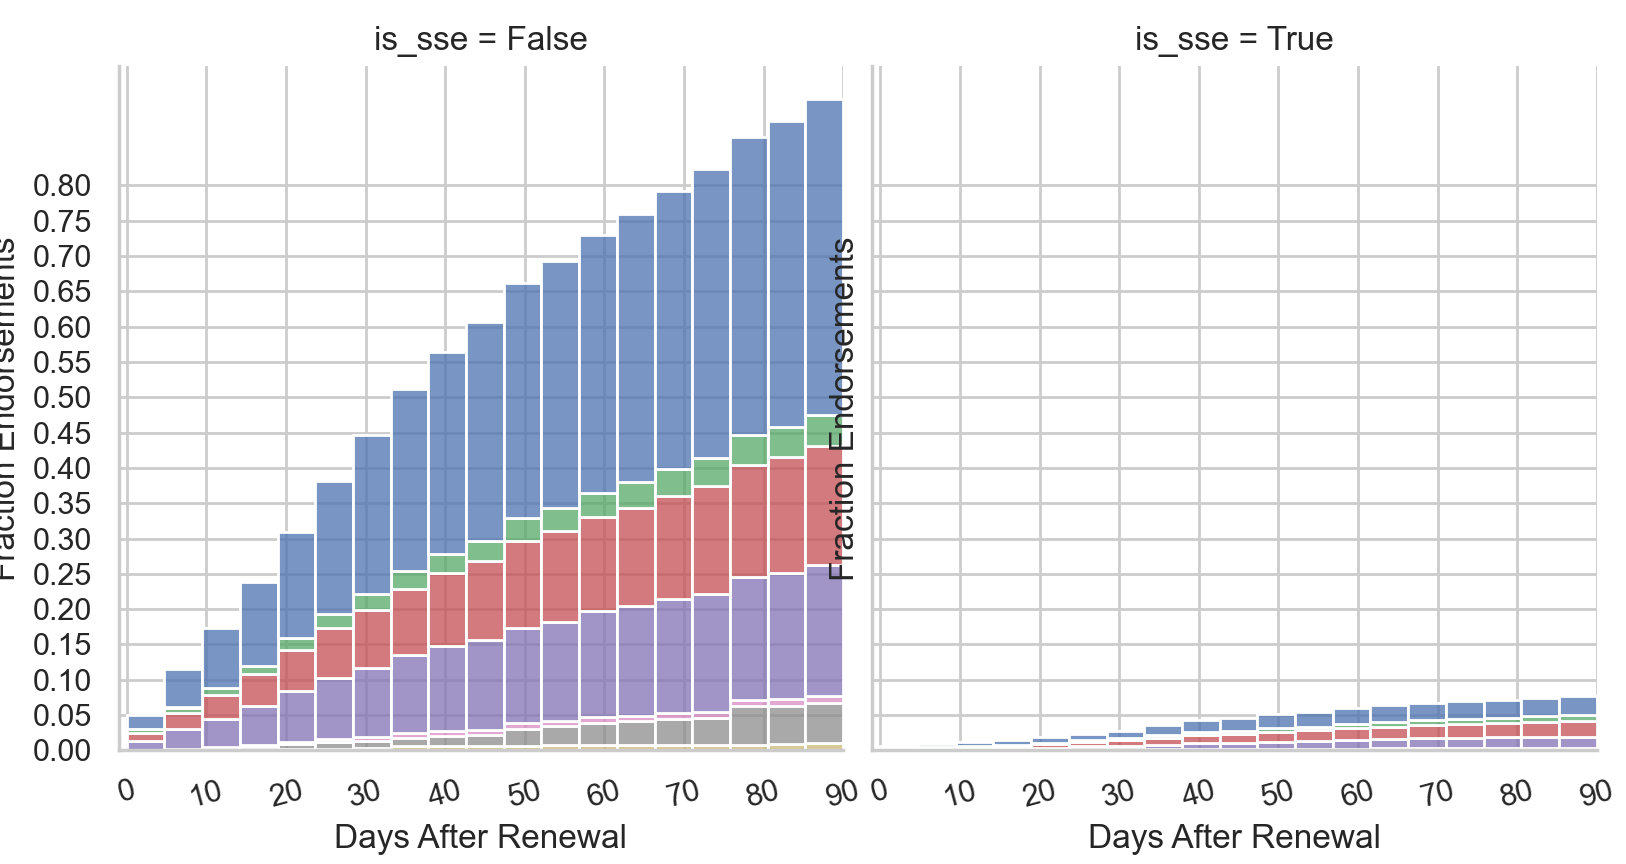

Text(0.5, 12.44444444444443, 'Days After Renewal')

Text(12.444444444444445, 0.5, 'Fraction Endorsements')

Text(0.5, 12.44444444444443, 'Days After Renewal')

Text(525.9791666666666, 0.5, 'Fraction Endorsements')

In [11]:
sns.set_theme(style="whitegrid");
df_filter = (~adf.year.isin(['2016', '2017'])) & (adf.days <= 90) & (
    adf.first_event == 'policy_action_renewal');

g = sns.displot(
    data=adf[df_filter],
    x="days", hue="broker_segment",
    col='is_sse',
    stat='probability',
    multiple="stack",
    hue_order=hue_order,
    #     edgecolor=".3",
    #     linewidth=.5,
    #     common_norm = True,
    cumulative=True,
    legend=False,
    #     facet_kws={"legend_out": False}
);

for ax in g.axes.squeeze():
    ax.set_xticks(np.arange(0, 91, 10));
    ax.set_yticks(np.arange(0, .81, .05));
    ax.xaxis.set_tick_params(rotation=15);
    ax.set_xbound(lower=-1, upper=90);
    ax.set_xlabel('Days After Renewal');
    ax.set_ylabel('Fraction Endorsements');

### Delinquency start-exit time distribution

#### Load event history CSV

In [17]:
!head -n3 ../data/sms_delinq_start_exit.csv

account_number,policy_number,event_history,event_ts,broker_segment,base_state,sms_subscribed
0010129441,REGRIG00001HIBP-47091-01,se,"{2020-10-03 00:00:00.000000,2020-10-06 19:58:46.000000}",Small Retail Subproducer (child),Texas,false
0021749452,UNTC00001HIBP-19149-01,e,{2020-10-16 19:04:01.000000},Small Retail Direct,New York,false


In [16]:
ddf = pd.read_csv('../data/sms_delinq_start_exit.csv', 
                  converters={'event_ts': pg_array2datetime_list})
ddf.head(2)

account_number             policy_number event_history  \
0        10129441  REGRIG00001HIBP-47091-01            se   
1        21749452    UNTC00001HIBP-19149-01             e   

                                     event_ts  \
0  [2020-10-03 00:00:00, 2020-10-06 19:58:46]   
1                       [2020-10-16 19:04:01]   

                     broker_segment base_state  sms_subscribed  
0  Small Retail Subproducer (child)      Texas           False  
1               Small Retail Direct   New York           False

#### Find start-exit event strings and calc durations

In [21]:
se_diffs = defaultdict(list)
BrokerAtts = namedtuple(
    'BrokerAtts', ['broker_segment', 'base_state', 'sms_subscribed'])

for row in ddf.itertuples(index=False):
    # get timestamp of start delinquency
    se_inds = find_all_match_group_positions('se', row.event_history)['se']
    # if SE event found
    if se_inds:
        for start_ind in se_inds:
            # calc start-exit duration (this fails with multi-character encoding!)
            start_ts = row.event_ts[start_ind]
            exit_ts = row.event_ts[start_ind+1]
            date_diff = timedelta2days(exit_ts - start_ts, tolerance=1)
            # construct groupby keys
            key = BrokerAtts(**dict([(k, row._asdict()[k])
                                     for k in BrokerAtts._fields]))
            se_diffs[key].append(date_diff)

#### Process results

In [26]:
rdf = pd.DataFrame(se_diffs.items(), columns=('key','data'))
for field in BrokerAtts._fields:
    rdf[field] = rdf['key'].map(lambda x: x._asdict()[field])
rdf.head(2)

key  \
0   (Small Retail Subproducer (child), Texas, False)   
1  (Small Retail Agency Network (child), North Ca...   

                                                data  \
0  [3.8, 2.9, 3.7, 3.8, 7.9, 22.3, 3.6, 20.1, 1.6...   
1          [3.1, 5.8, 6.8, 2.6, 6.8, 3.2, 5.9, 18.9]   

                        broker_segment      base_state  sms_subscribed  
0     Small Retail Subproducer (child)           Texas           False  
1  Small Retail Agency Network (child)  North Carolina           False

Num events per SMS group

In [25]:
rdf.explode('data').head()

key data  \
0  (Small Retail Subproducer (child), Texas, False)  3.8   
0  (Small Retail Subproducer (child), Texas, False)  2.9   
0  (Small Retail Subproducer (child), Texas, False)  3.7   
0  (Small Retail Subproducer (child), Texas, False)  3.8   
0  (Small Retail Subproducer (child), Texas, False)  7.9   

                     broker_segment base_state  sms_subscribed  
0  Small Retail Subproducer (child)      Texas           False  
0  Small Retail Subproducer (child)      Texas           False  
0  Small Retail Subproducer (child)      Texas           False  
0  Small Retail Subproducer (child)      Texas           False  
0  Small Retail Subproducer (child)      Texas           False

In [447]:
rdf.explode('data').groupby('sms_subscribed').count()

key  data  broker_segment  base_state
sms_subscribed                                       
False           863   863             861         863
True            111   111             111         111

Exit Time distribution

<IPython.core.display.Javascript object>


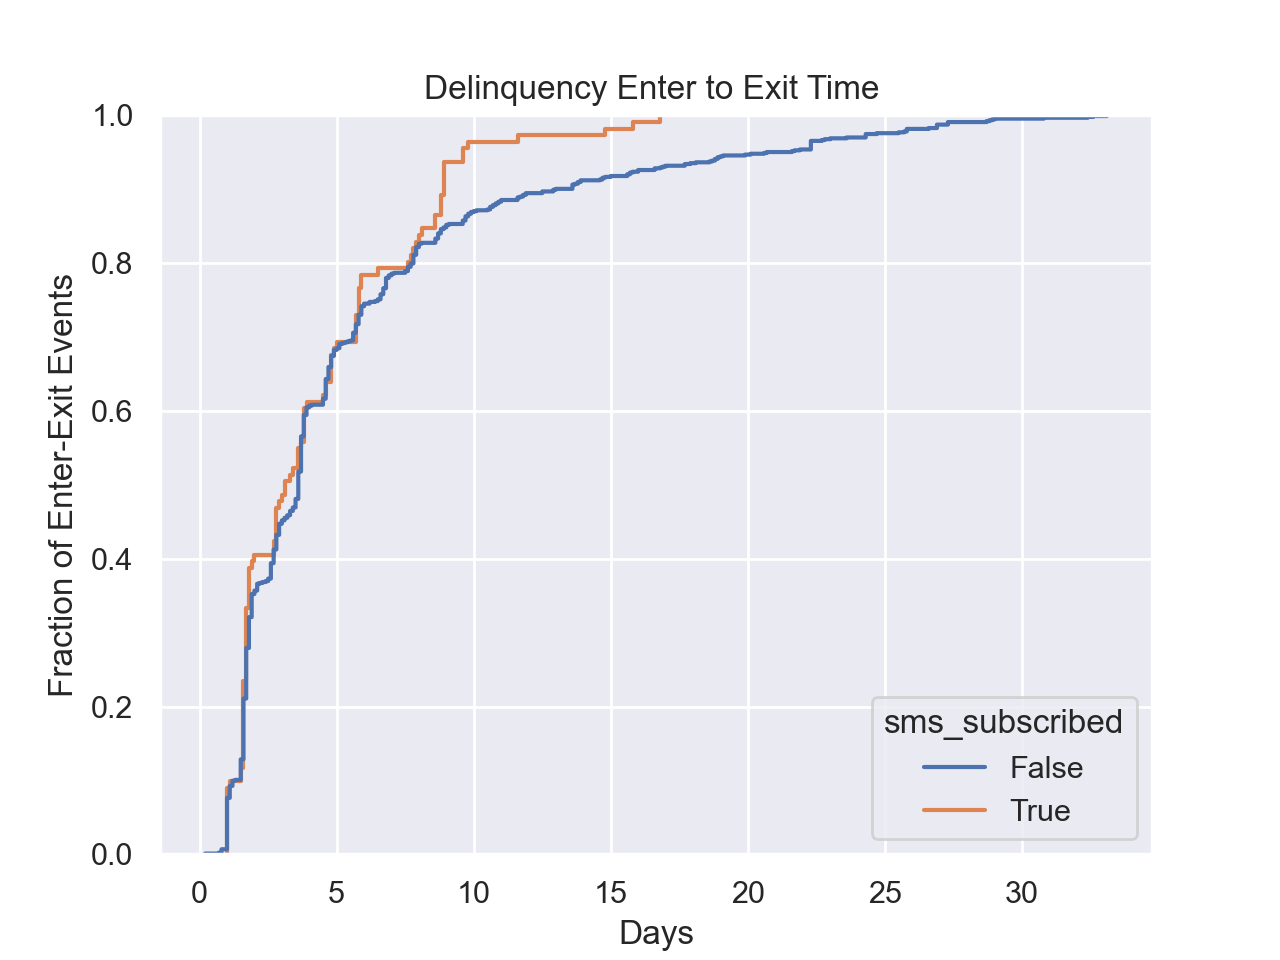

Text(0.5, 1.0, 'Delinquency Enter to Exit Time ')

Text(0.5, 0, 'Days')

Text(0, 0.5, 'Fraction of Enter-Exit Events')

In [27]:
#darkgrid, whitegrid, dark, white, and ticks
sns.set_theme(style="darkgrid")

_, ax = plt.subplots()
sns.ecdfplot(rdf.explode('data')
             , x="data"
             , hue="sms_subscribed"  
             , ax=ax
             )

ax.set_title('Delinquency Enter to Exit Time ')
ax.set_xlabel('Days')
ax.set_ylabel('Fraction of Enter-Exit Events')